In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd

import ROOT, uproot

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier

In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bora/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

Welcome to JupyROOT 6.18/04


In [3]:
def upsample(sample, scale):
    '''
    This function takes the sample and concatantes the same sample n times.
    '''
    if scale > 0:
        sample = np.vstack([sample]*scale)
    else:
        sample = sample
    return sample

In [4]:
input_branches = ['br_njets', 'br_nbjets', 'br_scalar_ht',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_met',
       'br_met_phi', 'br_sphericity', 'br_aplanarity', 'br_fox_wolfram_1',
       'br_fox_wolfram_2', 'br_fox_wolfram_3', 'br_fox_wolfram_4']

df_signal = uproot.open("/mnt/harddisk4/scratch/ttbar_no_dtG_flat.root")["outtree"].pandas.df(input_branches)
df_dyjets = uproot.open("/mnt/harddisk4/scratch/dyjets_flat_30M.root")["outtree"].pandas.df(input_branches)
df_wjets  = uproot.open("/mnt/harddisk4/scratch/wjets_flat_60M.root")["outtree"].pandas.df(input_branches)
df_single_top  = uproot.open("/mnt/harddisk4/scratch/single_top_merged_flat.root")["outtree"].pandas.df(input_branches)
print(df_signal.keys())
#print("n_signal:", len(df_signal), "n_dyjets:", len(df_dyjets), "n_wjets:", len(df_wjets), "n_single_top", len(df_single_top))

Index(['br_njets', 'br_nbjets', 'br_scalar_ht', 'br_jet_pt_1', 'br_jet_pt_2',
       'br_jet_pt_3', 'br_jet_pt_4', 'br_met', 'br_met_phi', 'br_sphericity',
       'br_aplanarity', 'br_fox_wolfram_1', 'br_fox_wolfram_2',
       'br_fox_wolfram_3', 'br_fox_wolfram_4'],
      dtype='object')


In [5]:
x_signal = df_signal.values
y_signal = np.full(len(x_signal) , 1)
print("number of signal events:%d" % (len(x_signal)))

x_dyjets = df_dyjets.values
x_wjets  = df_wjets.values
x_single_top  = df_single_top.values

x_wjets  = upsample(x_wjets,  int((len(x_signal)/len(x_wjets))))
x_dyjets = upsample(x_dyjets, int((len(x_signal)/len(x_dyjets))))
idx_max = int(0.33*len(x_signal))
x_bkg    = np.concatenate((x_dyjets[0:idx_max], x_wjets[0:idx_max], x_single_top[0:idx_max]), axis=0)
#x_bkg    = np.concatenate((x_dyjets[0:idx_max], x_single_top[0:idx_max]), axis=0)

#x_bkg    = x_single_top[0:idx_max]
y_bkg    = np.full(len(x_bkg) , 0)
print(idx_max)

number of signal events:135342
44662


In [6]:
x_sig_train, x_sig_test, y_sig_train, y_sig_test = train_test_split(x_signal, y_signal, test_size=0.2, random_state=20)
x_bkg_train, x_bkg_test, y_bkg_train, y_bkg_test = train_test_split(x_bkg, y_bkg, test_size=0.5, random_state=20)

x_train = np.concatenate((x_sig_train, x_bkg_train), axis=0)
y_train = np.concatenate((y_sig_train, y_bkg_train), axis=0)

x_test = np.concatenate((x_sig_test, x_bkg_test), axis=0)
y_test = np.concatenate((y_sig_test, y_bkg_test), axis=0)
                                  
scaler  = preprocessing.StandardScaler().fit(np.concatenate((x_train, x_test), axis=0))
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [7]:
print("training for", len(x_train), "events;", "testing for",  len(x_test), "events")

training for 175266 events; testing for 94062 events


In [8]:
model = model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(x_test), y_test)

0.8120813931236843

In [10]:
x_signal_trans = scaler.transform(x_signal)

In [11]:
output_array1 = model.predict_proba(scaler.transform(x_sig_train))[:,1]
output_array2 = model.predict_proba(scaler.transform(x_bkg_train))[:,1]

output_array3 = model.predict_proba(scaler.transform(x_sig_test))[:,1]
output_array4 = model.predict_proba(scaler.transform(x_bkg_test))[:,1]

In [12]:
#print(model.evaluate(x_train, y_train))
#print(model.evaluate(x_test, y_test))
#print(model.evaluate(scaler.transform(x_signal), y_signal))
#print(model.evaluate(scaler.transform(x_bkg), y_bkg))

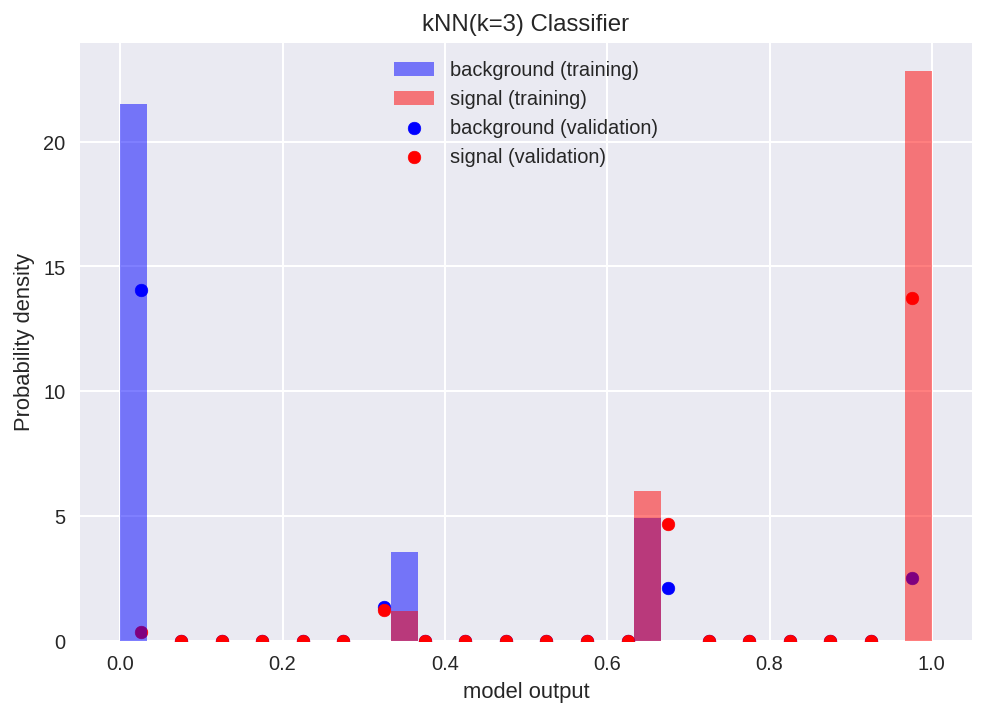

In [13]:
plt.style.use("seaborn")
fig, ax = plt.subplots()
n_bins = 20

y, bins, patches = ax.hist(output_array2, bins=n_bins, density=True, color='blue', alpha=0.5, label='background (training)')
y, bins, patches = ax.hist(output_array4, bins=n_bins, density=True, color='blue', alpha=0.0)
bin_centers = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
plt.scatter(bin_centers, y, marker='o', c='blue', s=40, alpha=1,  label='background (validation)')

y, bins, patches = ax.hist(output_array1, bins=n_bins, density=True, color='red', alpha=0.5, label='signal (training)')
y, bins, patches = ax.hist(output_array3, bins=n_bins, density=True, color='red', alpha=0.0)
bin_centers = [0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)]
plt.scatter(0.5*(bins[1:] + bins[:-1]), y, marker='o', c='red', s=40, alpha=1, label='signal (validation)')

ax.set_xlabel('model output')
ax.set_ylabel('Probability density')
ax.set_title("kNN(k=3) Classifier")
ax.legend()
#ax.set_yscale('log')

In [14]:
def get_signal_significance(xsec_sig, xsec_bkg, lumi, output_sig, output_bkg, thresholds):
    
    significance = []
    
    for threshold in thresholds:
        
        n_sig_expected = xsec_sig * lumi
        n_bkg_expected = xsec_bkg * lumi
        
        n_sig_pred_correct = len(output_sig[output_sig>threshold])
        n_sig_pred_wrong   = len(output_sig[output_sig<threshold])
        n_bkg_pred_correct = len(output_bkg[output_bkg<threshold])
        n_bkg_pred_wrong   = len(output_bkg[output_bkg>threshold])
        
        eff_sig = n_sig_pred_correct/len(output_sig)
        eff_bkg = n_bkg_pred_correct/len(output_bkg)
        
        n_sig = n_sig_expected * eff_sig
        n_bkg = n_bkg_expected * (1-eff_bkg)
        
        n_observed = n_sig + n_bkg
        
        if n_bkg > 0:
            sig = math.sqrt(2*n_observed*math.log(1+n_sig/n_bkg)-2*n_sig)
            #sig = n_sig/math.sqrt(n_sig+n_bkg)
        else:
            sig = 0
        
        print("threshold:", "{:.3f}".format(threshold), "\n"
              "eff_sig:", "{:.3f}".format(eff_sig),
              "eff_bkg:", "{:.3f}".format(eff_bkg),
              "n_sig:", "{:.0f}".format(n_sig), 
              "n_bkg:", "{:.0f}".format(n_bkg),
              "n_observed:", "{:.0f}".format(n_observed), "\n",
              "significance:", "{:.3f}".format(sig), "\n\n")
        
        significance.append(sig)    
        
    return thresholds, np.array(significance)

In [15]:
thresholds , significance = get_signal_significance(1, 100, 50000, output_array3, 
                                                    output_array4, np.arange(0.1, 1-1e-3, 1e-2))

threshold: 0.100 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.110 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.120 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.130 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.140 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.150 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.160 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.170 
eff_sig: 0.983 eff_bkg: 0.702 n_sig: 49128 n_bkg: 1490827 n_observed: 1539956 
 significance: 40.018 


threshold: 0.180 
eff_si

threshold: 0.820 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.830 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.840 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.850 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.860 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.870 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.880 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.890 
eff_sig: 0.687 eff_bkg: 0.874 n_sig: 34342 n_bkg: 631484 n_observed: 665826 
 significance: 42.833 


threshold: 0.900 
eff_sig: 0.687 eff_bkg

42.83273878822875


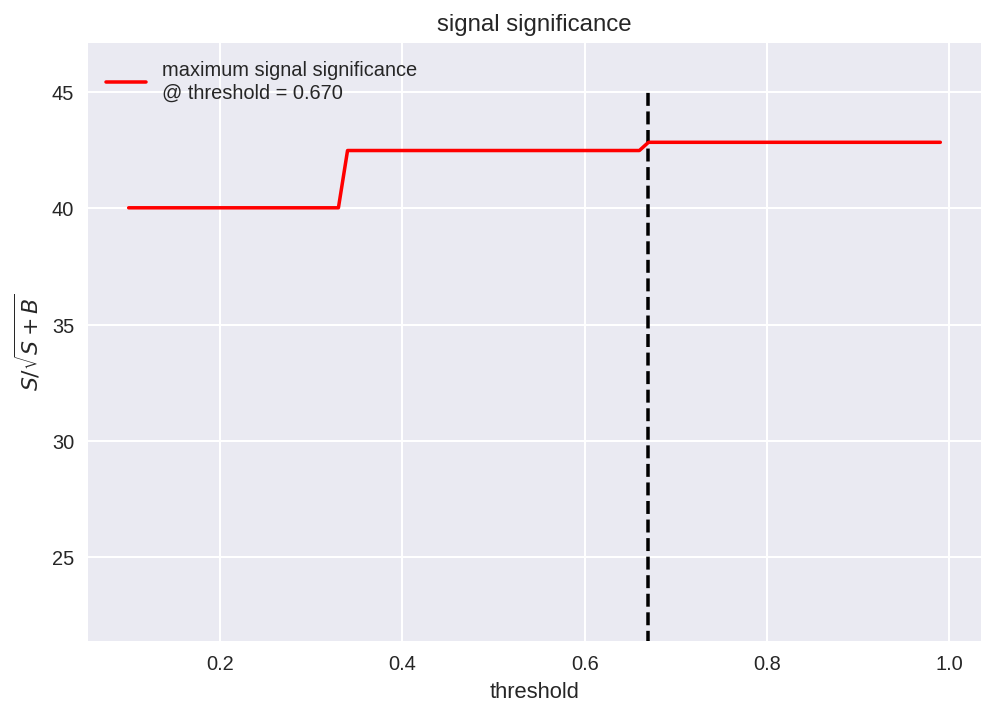

In [16]:
max_sig_threshold = thresholds[np.where(significance==max(significance))][0]
print(max(significance))
plt.figure(1)
plt.plot([max_sig_threshold, max_sig_threshold], [0, 1.05*max(significance)], 'k--')
plt.plot(thresholds, significance, label='maximum signal significance \n@ threshold = {:.3f}'.format(max_sig_threshold), color="red")
plt.xlabel('threshold')
plt.ylabel(r"$S/\sqrt{S+B}$")
plt.ylim([0.5*max(significance),1.1*max(significance)])
plt.title('signal significance')
plt.legend(loc="best")
plt.savefig("significance.pdf")

In [17]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict_proba(x_test)[:,1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

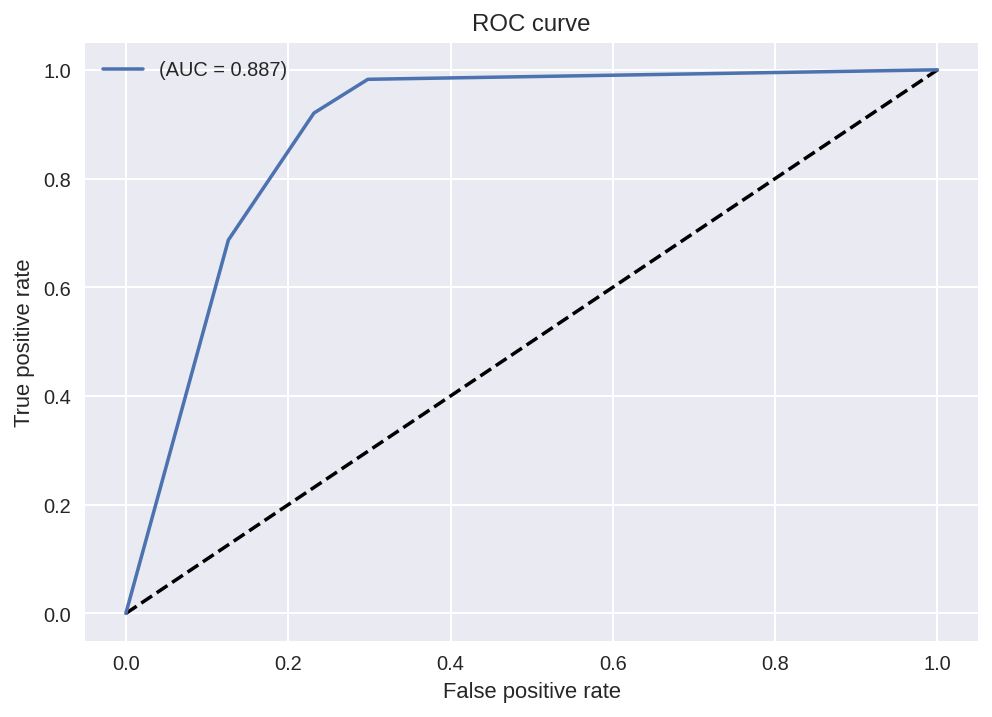

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras,tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, np.where(y_pred_keras > 0.5, 1, 0)).ravel()
accuracy    = (tp+tn)/len(y_test)
specificity = tn / (tn+fp)
sensitivity = tp / (tn+tp)
print("accuracy:", accuracy," specificity:", specificity, " sensitivity:", sensitivity);

accuracy: 0.8120813931236843  specificity: 0.7682892242473094  sensitivity: 0.32618542664886235
